# Simulation et Monte Carlo

In [2]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## Données angulaires 

Une loi classique pour des données correspondant à des angles observés sur l’intervalle [−π, π] est la loi de von Mises, de densité: $ π(θ) = \frac{1}{Z(κ)} exp(κ cos(θ − µ))$ où κ > 0, µ ∈ [−π, π], et Z(κ) est une constante de normalisation qui n’admet pas d’expression explicite. Cette loi est souvent qualifiée de loi normale pour les angles, car $cos(θ) ≈ 1 − θ^2$

### 1. Algorithme acceptation-rejet

In [3]:
def gen_uni_pi(n=1):
    return np.random.uniform(-np.pi, np.pi, n)

In [8]:
def unipi_density(x) :
    if x <= np.pi and x >= -np.pi:
        return 1/(2*np.pi)
    else:
        return 0
    
v_unipi_density = np.vectorize(unipi_density)

def von_mises_density(x, mu=0, kappa=1):
    return np.exp(kappa * np.cos(x - mu))

In [10]:
y = np.linspace(-np.pi, np.pi)

M = np.max(von_mises_density(y, mu=0, kappa=1)/v_unipi_density(y))

In [11]:
M

17.044412870709813

In [23]:
def von_mises_ra():
    while True :
        x = gen_uni_pi()
        M = 17.1
        u = rd.random()

        if u <= (1/M)*von_mises_density(x)/(unipi_density(x)):
            return x 

C:\Users\elisa\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

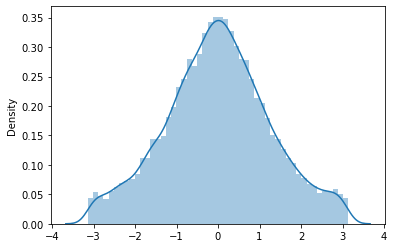

In [24]:
sns.distplot([von_mises_ra() for i in range(20000)])

### 2. Algorithme de Metropolis

Proposer un algorithme de Metropolis simple pour simuler selon une telle loi; notamment proposer une règle simple pour que 
la performance de l’algorithme ne dépende pas des paramètres. 
(Expliquer ce que veut dire le mot “performance” pour un tel algorithme.)

Contrairement à l'algorithme de rejet, MCMC crée des va qui ne sont pas indépendantes les unes des autres